In [1]:
# import my librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import gsw
from sklearn.linear_model import LinearRegression

In [2]:
ctcoeff = np.array([0.01177633, 0.01339866, 0.01364187, 0.01361233, 0.00841783,
        0.00603842, 0.00609427, 0.00814836, 0.00446391, 0.00444536,
        0.00381594, 0.00379695, 0.00251232, 0.00251442])
profile_speed = np.array([ 7.1,  7.1,  7.1,  7.1, 13.2, 15. , 18.9 , 12.8, 24.2 , 24.5 , 31.3 ,
        31.3 , 42.7 , 43.2 ])

In [75]:
supercounter = 4

for files in np.arange(3,4,1):#np.arange(1,13,1):
    # SET METADATA FOR EACH TEST
    if files==1:
        filename = 'datasets/flume/day2/208077_20211006_1123.rsk'
        numtest = 1
        indstart = [70290]
        indend = [118300]
        speed = [7.1]
        mycolor = 'b'
        
    elif files ==2:
        filename = 'datasets/flume/day2/208077_20211006_1318.rsk'
        numtest = 2
        indstart = [2682,125600]
        indend = [45580,175800]
        speed = [7.1,7.1]
        mycolor = ['b','b']

    elif files ==3:
        filename = 'datasets/flume/day2/208077_20211006_1504.rsk'
        numtest = 2
        indstart = [3701,126000]
        indend = [48860,164300]
        speed = [7.1,13.2]
        mycolor = ['b','g']
                
    elif files ==4:
        filename = 'datasets/flume/day2/208077_20211006_1601.rsk'
        numtest = 1
        indstart = [716]
        indend = [56980]
        speed = [15]
        mycolor = 'm'        
                
    elif files ==5:
        filename = 'datasets/flume/day3/208077_20211007_1031.rsk'
        numtest = 1
        indstart = [73580]
        indend = [109880]
        speed = [18.9]
        mycolor = 'm'        
                
    elif files ==6:
        filename = 'datasets/flume/day3/208077_20211007_1116.rsk'
        numtest = 1
        indstart = [14320]
        indend = [53190]
        speed = [12.8]
        mycolor = 'g'        
                
    elif files ==7:
        filename = 'datasets/flume/day3/208077_20211007_1150.rsk'
        numtest = 1
        indstart = [10350]
        indend = [50405]
        speed = [24.2]   
        mycolor = 'y'        

    elif files ==8:
        filename = 'datasets/flume/day3/208077_20211007_1232.rsk'
        numtest = 1
        indstart = [21940]
        indend = [60786]
        speed = [24.5]   
        mycolor = 'y'        
        
    elif files ==9:
        filename = 'datasets/flume/day3/208077_20211007_1304.rsk'
        numtest = 1
        indstart = [8093]
        indend = [48135]
        speed = [31.3]   
        mycolor = 'r'        
        
    elif files ==10:
        filename = 'datasets/flume/day3/208077_20211007_1342.rsk'
        numtest = 1
        indstart = [0]
        indend = [41255]
        speed = [31.3]   
        mycolor = 'r'        
        
    elif files ==11:
        filename = 'datasets/flume/day3/208077_20211007_1425.rsk'
        numtest = 1
        indstart = [0]
        indend = [49955]
        speed = [42.7]   
        mycolor = 'b'        
        
    elif files ==12:
        filename = 'datasets/flume/day3/208077_20211007_1507.rsk'
        numtest = 1
        indstart = [1433]
        indend = [43272]
        speed = [43.2]
        mycolor = 'b'        
        
        
    # Create a SQL connection to our SQLite database
    con = sqlite3.connect(filename)

    # query the data
    df = pd.read_sql_query("SELECT tstamp AS time, channel01 AS Cmeas, channel02 AS Tmeas, channel03 AS Pmeas, channel07 AS Tcond from data", con)
    con.close()

    # deal with time and date
    df['date'] = pd.to_datetime(df['time'],unit='ms')
    df = df.set_index('date')

    # compute secondary variables
    # computes approximate Sea Pressure
    df['Sea Pressure'] = df['Pmeas']-10.13
    # computes practical Salinity
    df['Smeas'] = gsw.SP_from_C(df['Cmeas'],df['Tmeas'],df['Sea Pressure'])
        
#    for test in np.arange(0,numtest,1):
    for test in np.arange(1,2,1):

        # Crop the dataset
        rbr = df[indstart[test]:indend[test]]

        # Record flume speed
        profile_speed[supercounter] = speed[test]

        # compute normalized variables
        Tinit = np.nanmean(rbr.Tmeas[0:32*5])
        Tfinal = np.nanmean(rbr.Tmeas[-32*10:-1])
        Sinit = np.nanmean(rbr.Smeas[0:32*5])
        Sfinal = np.nanmean(rbr.Smeas[-32*10:-1])

        rbr['TN'] = 1- (rbr.Tmeas - Tinit)/(Tfinal - Tinit)
        #rbr['SN'] = np.real(np.log(1-(rbr.Smeas - Sinit)/(Sfinal - Sinit)))

        # Compute elasped time
        t0 = np.where(rbr.TN<0.01)[0][0]
        rbr['etime'] = (rbr.time - rbr.time[t0])/1000
        
        # Apply CT lag
        deltat = 0.35
        rbr['Tcor'] = np.interp(rbr.etime+ deltat,rbr.etime,rbr.Tmeas)
        
        # define reference salinity and conductivity a Salinity in last 10s
        Sref = Sfinal
        
        # Compute Tanomaly
        rbr['Tanomaly'] = np.nan*rbr.Tcor;
        blop = np.where(rbr.TN<0.05)[0];
        Tspace= np.arange(0,40,0.001)
        for ii in blop:
            Cspace = rbr.Cmeas[ii]*np.ones(Tspace.size);
            Sspace = gsw.SP_from_C(Cspace,Tspace,rbr['Sea Pressure'][ii]);
            I = np.argmin(np.abs(Sspace-Sref));
            rbr.Tanomaly[ii] = Tspace[I] - rbr.Tcor[ii];
            
        rbr['Tlong'] = ctcoeff[supercounter]*(rbr.Tcond-rbr.Tcor)
        rbr['Scor'] = gsw.SP_from_C(rbr.Cmeas,rbr.Tcor+rbr.Tlong,rbr['Sea Pressure'])
        rbr['SNcor'] = np.real(np.log(1-(rbr.Scor - Sinit)/(Sfinal - Sinit)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

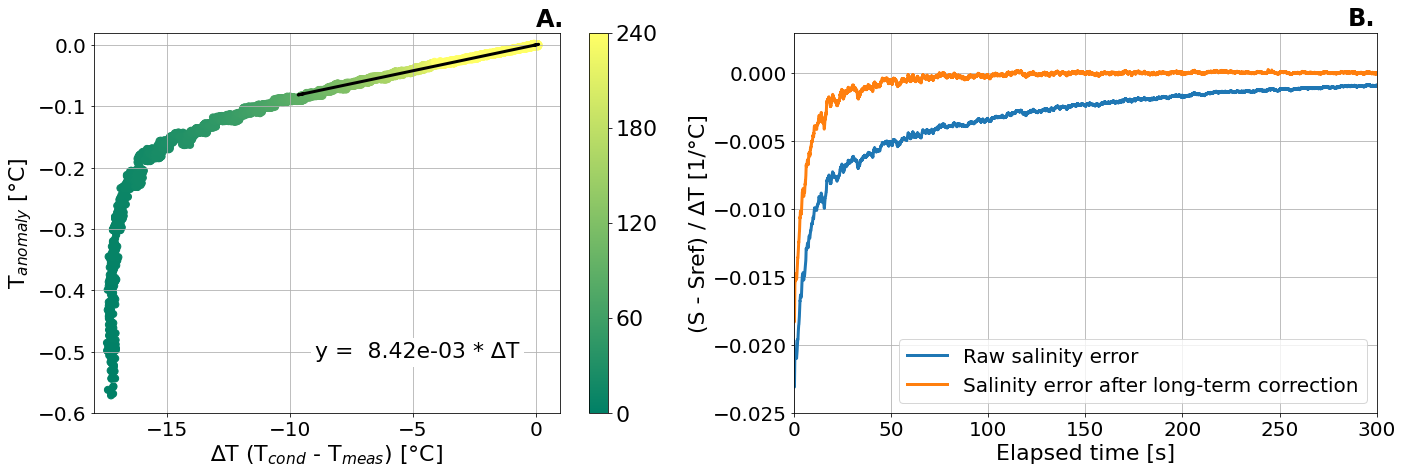

In [133]:
fig,ax = plt.subplots(1,2,figsize=(23,7),facecolor='w')

sc = ax[0].scatter(rbr.Tcond[rbr.etime>0]-rbr.Tmeas[rbr.etime>0],rbr.Tanomaly[rbr.etime>0],50, rbr.etime[rbr.etime>0],label='raw Salinity error',vmin=0, vmax=240,cmap='summer')
ax[0].plot(rbr.Tcond[rbr.etime>90]-rbr.Tmeas[rbr.etime>90],ctcoeff[supercounter]*(rbr.Tcond[rbr.etime>90]-rbr.Tmeas[rbr.etime>90]), lw=3, c='k')
#Pastel2_r
ax[0].set_ylim(-.6,0.02)
ax[0].set_xlim(-18,1)
cbar = fig.colorbar(sc,ax=ax[0], ticks=[0, 60, 120, 180, 240])
cbar.ax.tick_params(labelsize=22)
ax[0].grid()
ax[0].set_ylabel('T$_{anomaly}$ [°C]', fontsize=22)
ax[0].set_xlabel('∆T (T$_{cond}$ - T$_{meas}$) [°C]', fontsize=22)
#ax[0].set_title('Profiling speed: '+str(speed[test])+' cm/s', fontsize=22)
ax[0].text(0,0.03,'A.',fontsize=24,weight='bold')
ax[0].tick_params(axis='both', which='major', labelsize=20)
txt = 'y = {coef: .2e} * ∆T'
ax[0].text(-9,-0.51,txt.format(coef = ctcoeff[supercounter]),fontsize=22,backgroundcolor='w')

ax[1].plot(rbr.etime,(rbr.Smeas-Sref)/(Tfinal - Tinit), label='Raw salinity error',lw=3)
ax[1].plot(rbr.etime,(rbr.Scor-Sref)/(Tfinal - Tinit), label='Salinity error after long-term correction',lw=3)
ax[1].set_xlim(-0,300)
ax[1].set_ylim(-0.025,0.003)
plt.legend(loc='lower right', fontsize=20)
ax[1].grid()
ax[1].set_ylabel('(S - Sref) / ∆T [1/°C]', fontsize=22)
ax[1].set_xlabel('Elapsed time [s]', fontsize=22)
#ax[1].set_title('Profiling speed: '+str(speed[test])+' cm/s', fontsize=22)
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].text(285,0.0035,'B.',fontsize=24,weight='bold')

plt.savefig('Fig9_long_term_TM.png',bbox_inches='tight')
